In [39]:
using Pkg 

Pkg.activate("..")

using MiCRM_stability
using LinearAlgebra
using StatsBase
using Distributions
using JLD2
using Random
using Graphs

using CairoMakie

  Activating project at `~/Projects/MiCRM_stability`


In [46]:
#get parameter names
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)
fs = filter(x -> x ∉ [:χ,:D, :ϕ_norm_inv,:γ, :η], fs)
    
names =  vcat(fe...,fs..., "Cu", "Cd", "m/g")

# #latex names
fe_L = [L"g^{(x)}",L"g^{(s)}",L"m^{(x)}",L"f^{(y)}",L"\lambda^{(g)}",L"i^{ (y)}",L"o^{(y)}"]
fs_L = [L"\alpha",L"\beta",L"\Lambda^*",L"\Omega^*",L"\rho",L"\tilde{\rho}",L"\sigma",L"\tilde{\sigma}",L"C_U", L"C_D",L"mg"]

# # #concatanate
names = string.(names)
names_L = vcat(fe_L,fs_L)



# # #load
res = load("../Results/data/new_sims/dynamic_stabiltiy.jld2")

Dict{String, Any} with 2 entries:
  "l" => Complex[-0.000825695+0.0im, 3.21461e-16+0.0im, -0.00276253+0.0im, -0.0…
  "p" => Any[[1.00822, 1.09826, 1.06431, 1.40327, 0.0, 0.343668, 1.1168, 0.8416…

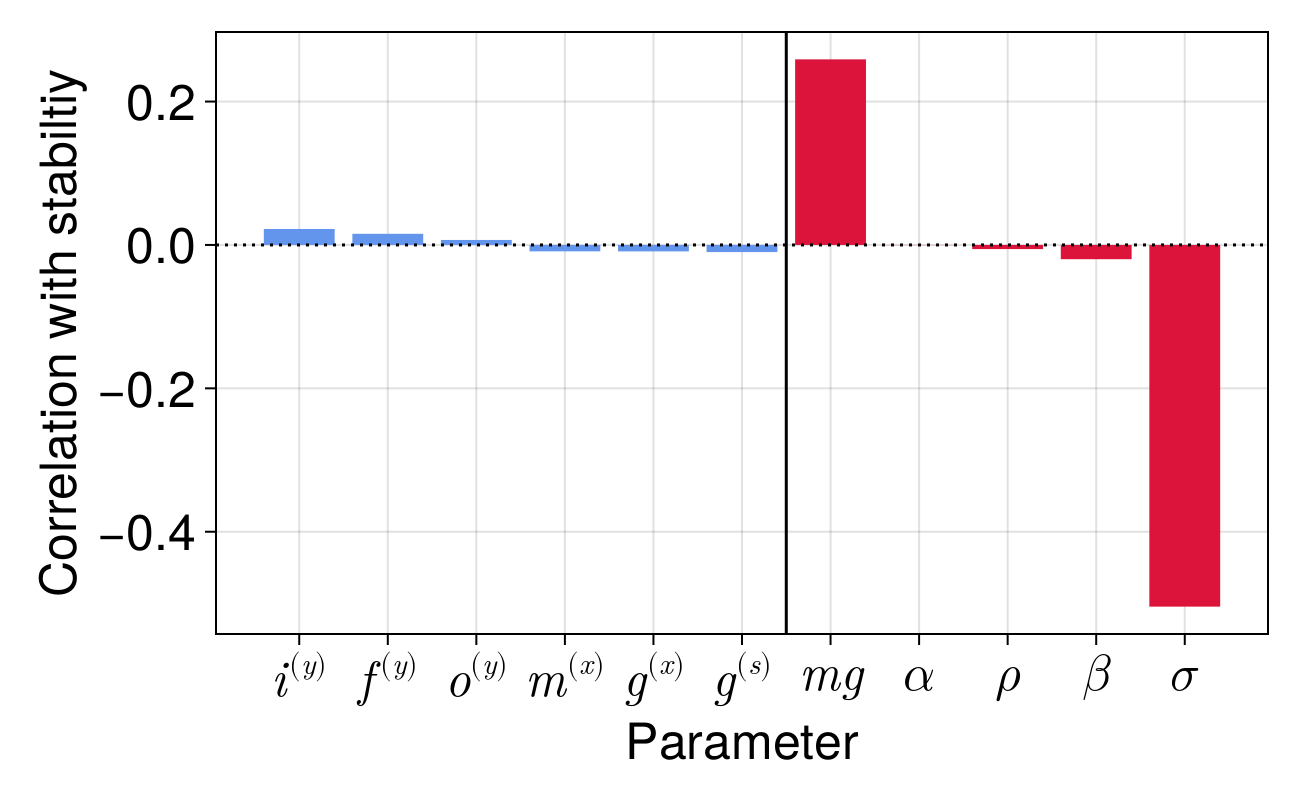

In [47]:
# #filter parameters
p_ind = collect(eachindex(names))
rm_ind = findall(names .∈ Ref(["γ","η","χ","ϕ","σ̃","ρ̃","Λ","Ω","Cu","Cd"]))
p_ind = filter(x -> x .∉ Ref(rm_ind), p_ind)

#filter name vectors
names_1 = names[p_ind]
names_L_1 = names_L[p_ind]

#get stability and correlate
p_mat = hcat(res["p"]...)[p_ind,:]
stab = [x.re < 0 for x = res["l"]]
stability_cor = [cor(abs.(p), stab) for p = eachrow(p_mat)]

# #get color
c = vcat(fill(:cornflowerblue, length(fe_L)), fill(:crimson, length(fs_L)))
c = c[p_ind]

# # #sort
# ind = sortperm((stability_cor),rev=true)
ind = vcat(sortperm((stability_cor[1:7]),rev=true), 7 .+ sortperm((stability_cor[8:12]),rev=true))

f = Figure(size = (650,400))
ax = Axis(f[1,1], xticks = (1:length(names_1), names_L_1[ind]),
    xlabel = "Parameter", ylabel = "Correlation with stabiltiy",
    xticklabelsize = 25, yticklabelsize = 25,
    xlabelsize = 25, ylabelsize = 25)

barplot!(ax, stability_cor[ind], color = c)
hlines!(ax, [0], linestyle = :dot, color = "black")
vlines!(ax, [7.5], color = :black)

f

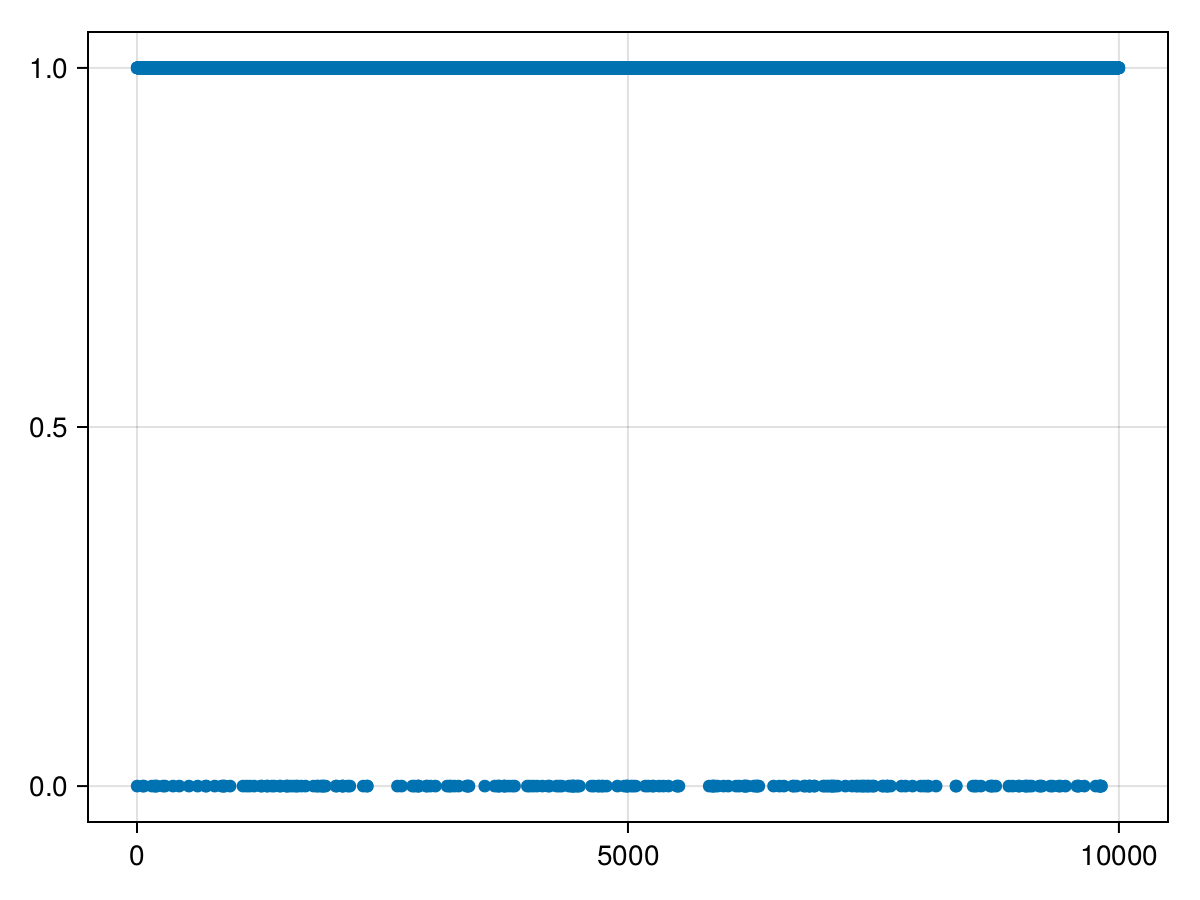

In [48]:
stab |> plot

In [4]:
save("../Results/Figures/stability_correlations.svg", f)
save("../Results/Figures/stability_correlations.pdf", f)

CairoMakie.Screen{PDF}


# Switching

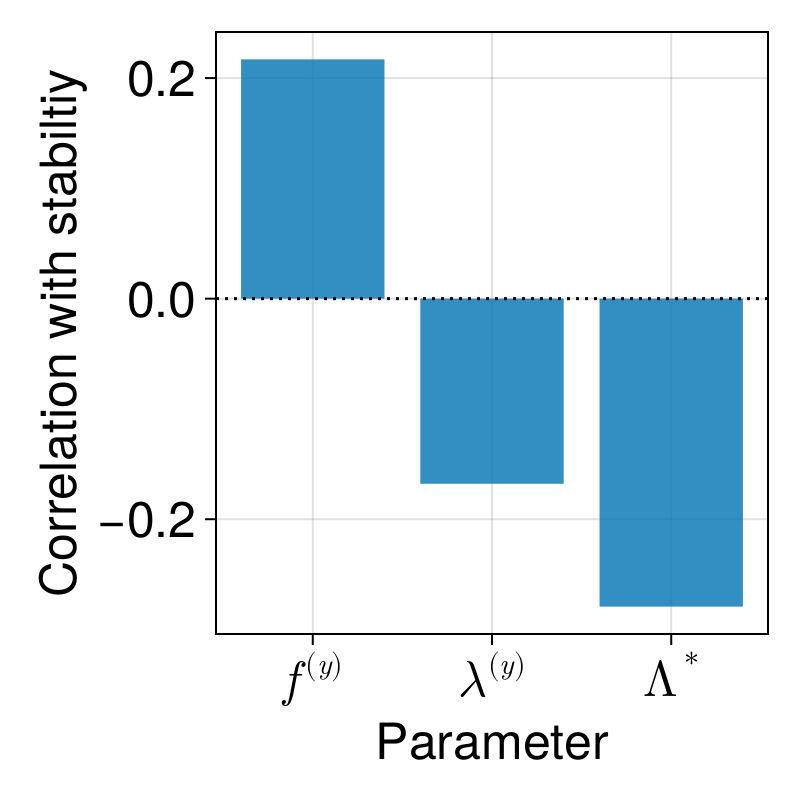

In [5]:

p_mat = hcat(res["p"]...)

ind = findall(names .∈ Ref(["fy","λy","Λ"]))

stability_cor = [cor(abs.(p), stab) for p = eachrow(p_mat[ind,:])]


f = Figure(size = (400,400))
ax = Axis(f[1,1], xticks = (1:length(names[ind]), names_L[ind]),
    xlabel = "Parameter", ylabel = "Correlation with stabiltiy",
    xticklabelsize = 25, yticklabelsize = 25,
    xlabelsize = 25, ylabelsize = 25)

barplot!(ax, stability_cor)
hlines!(ax, [0], linestyle = :dot, color = "black")
# vlines!(ax, [5.5], color = :black)

f

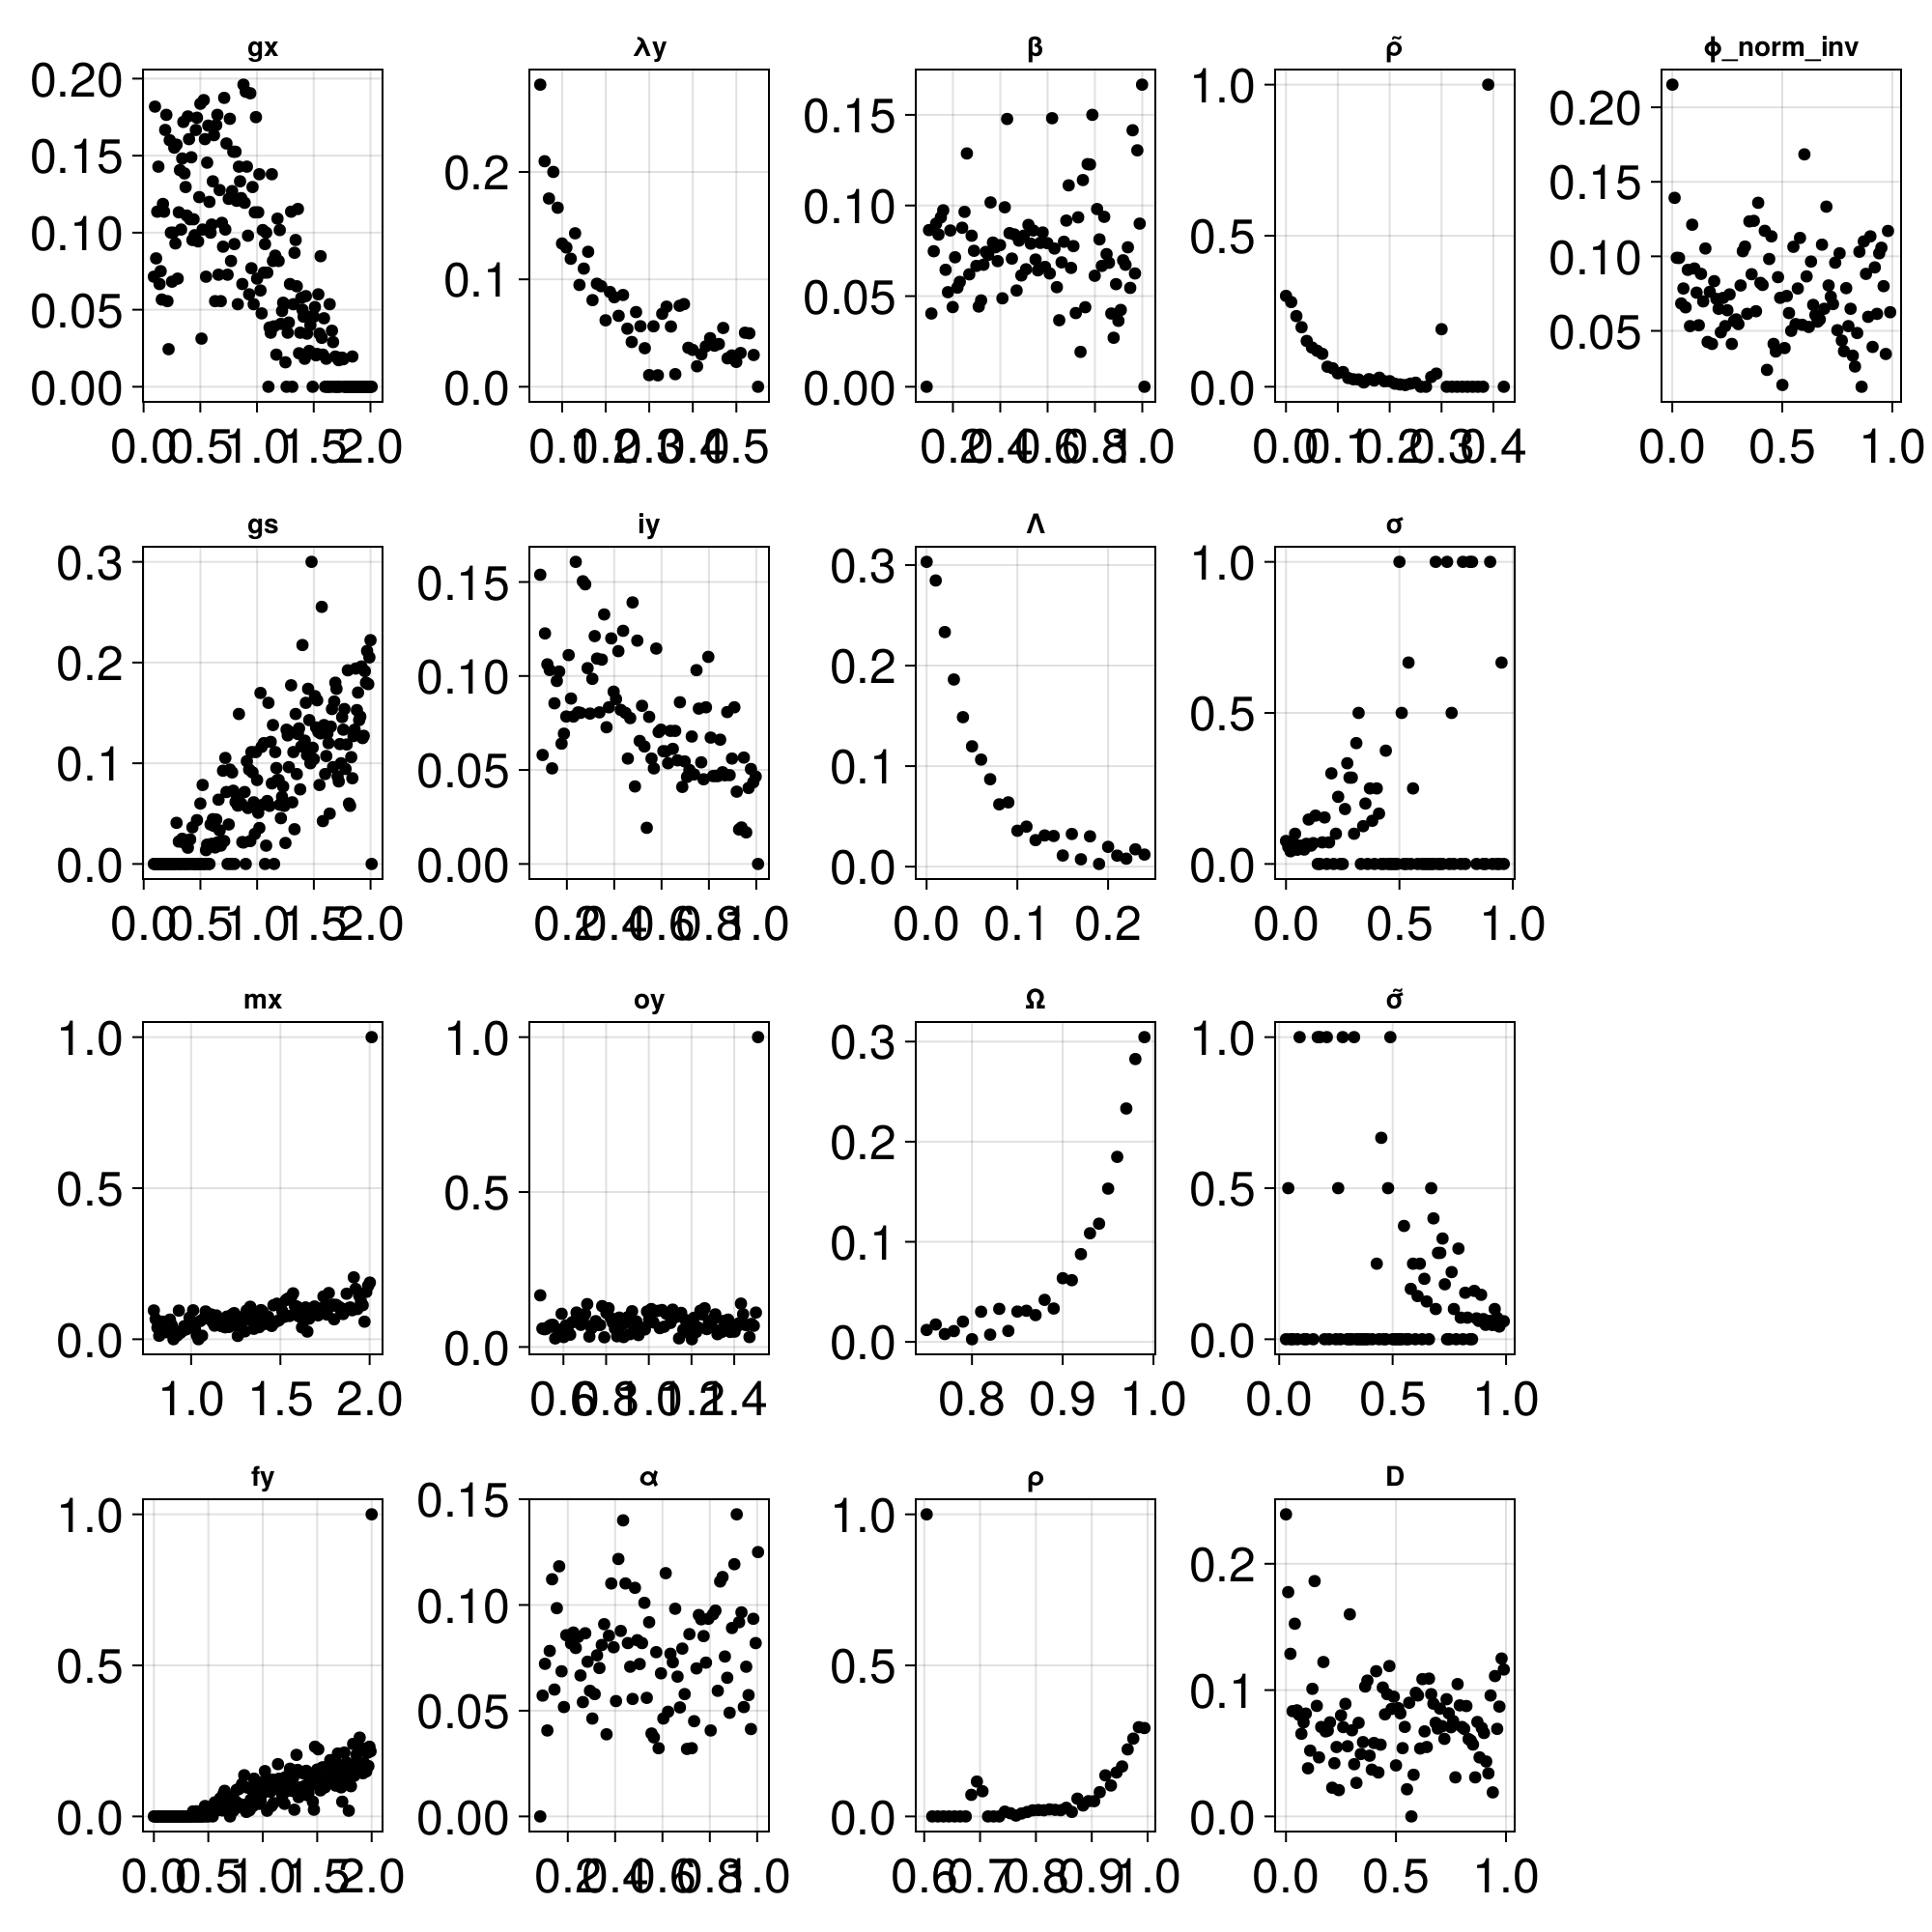

In [6]:
f = Figure(size = (1000,1000))

#get parameter names
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)
fs = filter(x -> x ∉ [:χ,:ϕ,:γ, :η], fs)
    
names =  vcat(fe...,fs..., "Cu", "Cd")

for i = 1:17
    # println((i-1) ÷ 4)
    p_vec = hcat(res["p"]...)[i,:]
   
        
    d = 0.01
    xvec = minimum(p_vec):d:maximum(p_vec)
    
    stab_binned = [stab[(i .< p_vec .< i + d)] |> mean for i = xvec]
    
    
    ax = Axis(f[(i-1) % 4, (i-1) ÷ 4], xlabel = "", ylabel = "", 
        xticklabelsize = 25, yticklabelsize = 25,
        xlabelsize = 25, ylabelsize = 25, title = string(names[i]))
    
    plot!(ax, xvec, stab_binned, color = (:black))
    # errorbars!(ax, xvec,stab, stab_var)
    # ylims!(0,1)
end
f

# size

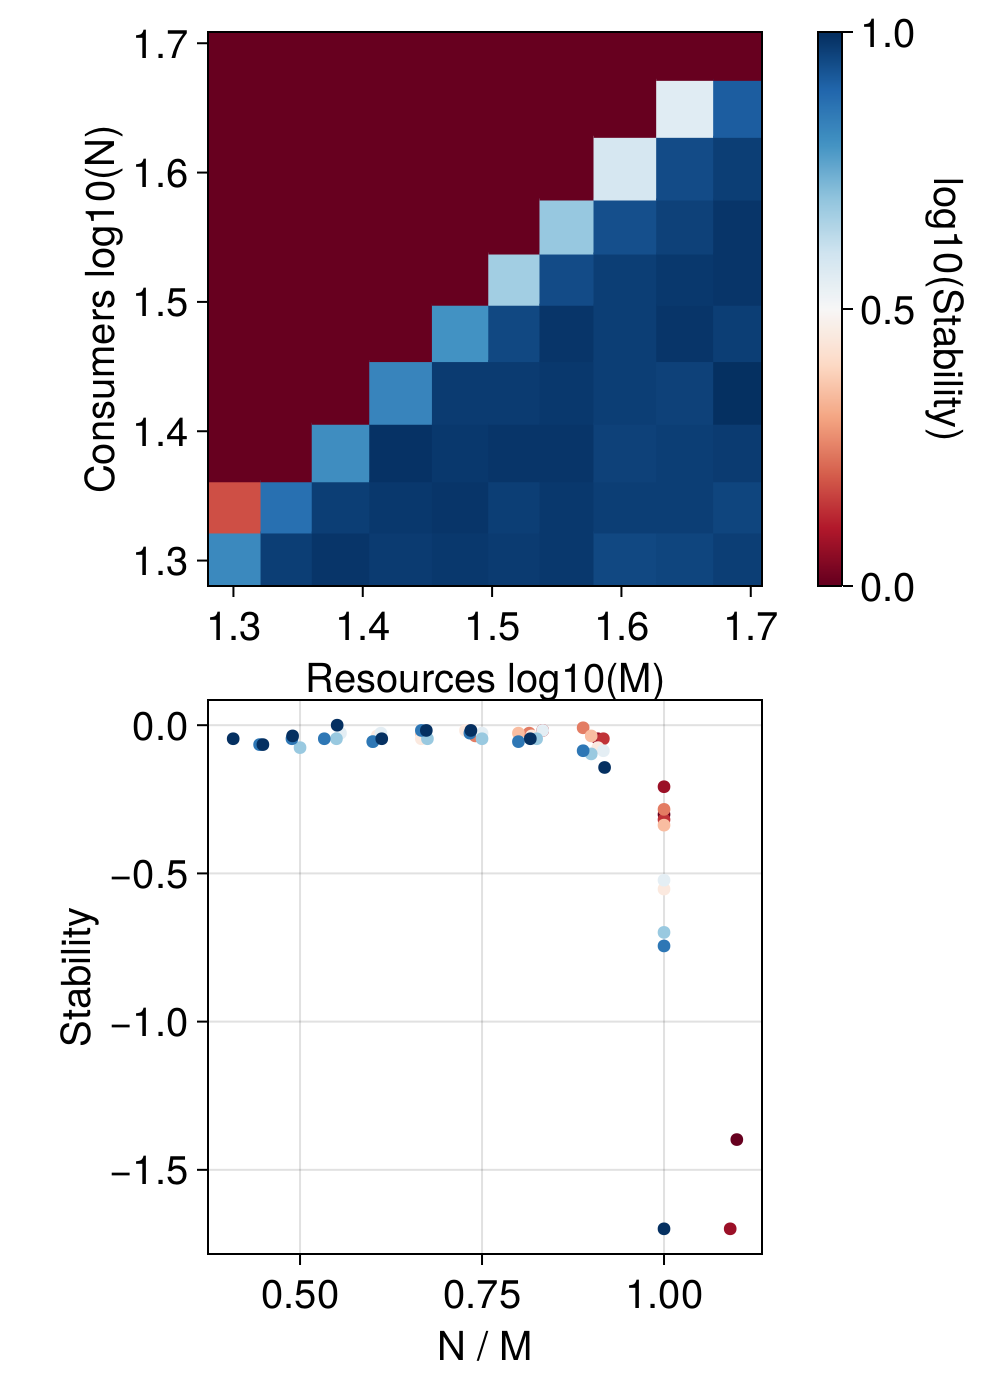

In [13]:
res = load("../Results/data/new_sims/size_stability.jld2")

stab = [(x.re) .< -eps() for x = res["l"]];
stab = stab[:,:,:,2];

#params
#params
N = 10
M = 10
Np = 50
nK = 10


n_vec = Int.(floor.(10 .^ range(log10(20), log10(50), length = N)))
m_vec = Int.(floor.(10 .^ range(log10(20), log10(50), length = M)))
k_vec = 10 .^ range(-5,-1, nK) 
N_mat = [n_vec[i] for i = 1:N, j = 1:M]
M_mat = [m_vec[j] for i = 1:N, j = 1:M]

stab = mean(stab,dims=3)[:,:,1]


f = Figure(size = (500,700))

#plot stabiltiy heatmap
ax = Axis(f[1,1], ylabel = "Consumers log10(N)", xlabel = "Resources log10(M)", aspect = 1, xticklabelsize = 20, yticklabelsize = 20, xlabelsize = 20, ylabelsize = 20)
cm = :RdBu

heatmap!(ax, log10.(m_vec), log10.(n_vec), log10.(stab'), colormap = (cm))
Colorbar(f[1,2], colormap = (cm), label = "log10(Stability)", 
    flip_vertical_label = true, labelsize = 20, ticklabelsize = 20, tellwidth = false, tellheight = false)

cm = :RdBu

ind = (stab[:] .> 0) 
ax2 = Axis(f[2,1], aspect = 1, ylabel = "Stability", xlabel = "N / M", xticklabelsize = 20, yticklabelsize = 20, xlabelsize = 20, ylabelsize = 20)
scatter!(ax2, ( (N_mat[ind] ./ M_mat[ind] )  ), log10.(stab[ind]),  colormap = (cm), color = Float64.(M_mat[ind]))

colsize!(f.layout, 2, Relative(0.03))
rowgap!(f.layout,0.)

f

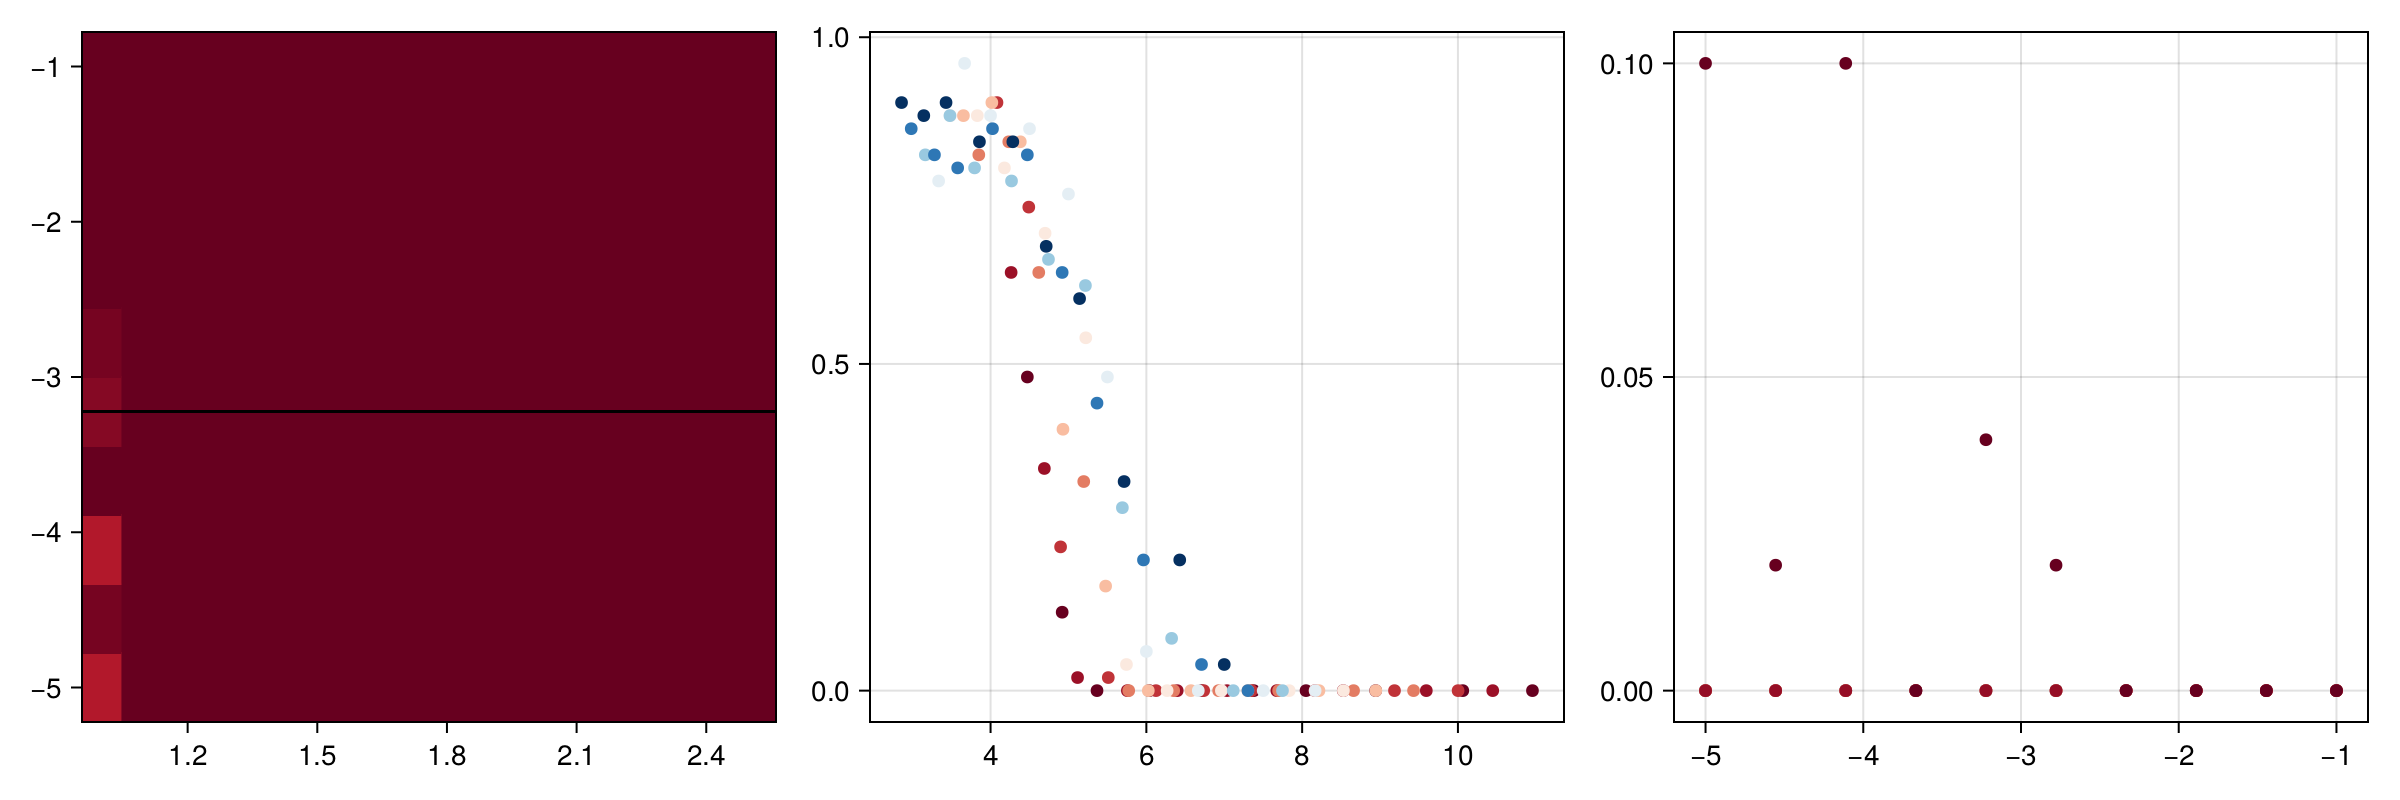

In [15]:
using GLM

res = load("../Results/data/new_sims/size_stability.jld2")

stab = [(x.re) .< -eps()  for x = res["l"]];
stab = mean(stab[:,:,:,:], dims = 3)[:,:,1,:]

n = 10
k = 5

f = Figure(size = (1200,400))
ax = Axis(f[1,1])
heatmap!(ax,n_vec[n] ./ m_vec, log10.(k_vec), stab[n,:,:], colormap = :RdBu, colorrange = (0,1))
hlines!(ax, log10.(k_vec)[k], color = :black)

ax = Axis(f[1,2])
for i = eachindex(n_vec)
    c = m_vec
    α = 0.5
    scatter!(ax, n_vec[i] ./ (m_vec .^ α)  , stab[i,:,k], color = c, colorrange = extrema(c), colormap = :RdBu)

    X = n_vec[i] ./ (m_vec .^ α)  
    Y = stab[i,:,k]
    # mask = X .<= 7.0

    # data = (; X = X[mask], Y = Y[mask])
    # mod = lm(@formula(Y~X), data)
    # ablines!(ax, GLM.coef(mod)...)

    # println(GLM.coef(mod))
    
end

ax = Axis(f[1,3])
for i = eachindex(m_vec)
    c = n_vec[n] / m_vec[i]
    scatter!(ax, log10.(k_vec) , stab[n,i,:], color = c, colorrange = extrema(n_vec[n] ./ m_vec), colormap = :RdBu)
end

f

In [62]:
using Interpolations, Statistics

α=1.0

function mr_f(α)
    x = N_mat[2:end,2:end] ./ M_mat[2:end, 2:end].^α
    y = log10.(stab[2:end, 2:end])
    
    
    x_grid = range(0.1,3.0, length = 100)  
    interp = zeros(M-1,100)
    # # Define a common x-grid to interpolate onto
    for i = 1:(M-1)
        itp = LinearInterpolation(x[:,i], y[:,i], extrapolation_bc=NaN)
        interp[i,:] = itp.(x_grid) 
    end
    
    interp[isnan.(interp)] .= -Inf
    
    resid = (interp .- [mean(interp[interp[:,i] .> -Inf,i]) for i = 1:100]') .^ 2
    mr = [resid[.!isnan.(resid[:,i]) .&& resid[:,i] .< Inf,i] |> mean for i = 1:100]
    tot_r = mr[.!isnan.(mr)] |> mean
end

mr_f (generic function with 1 method)

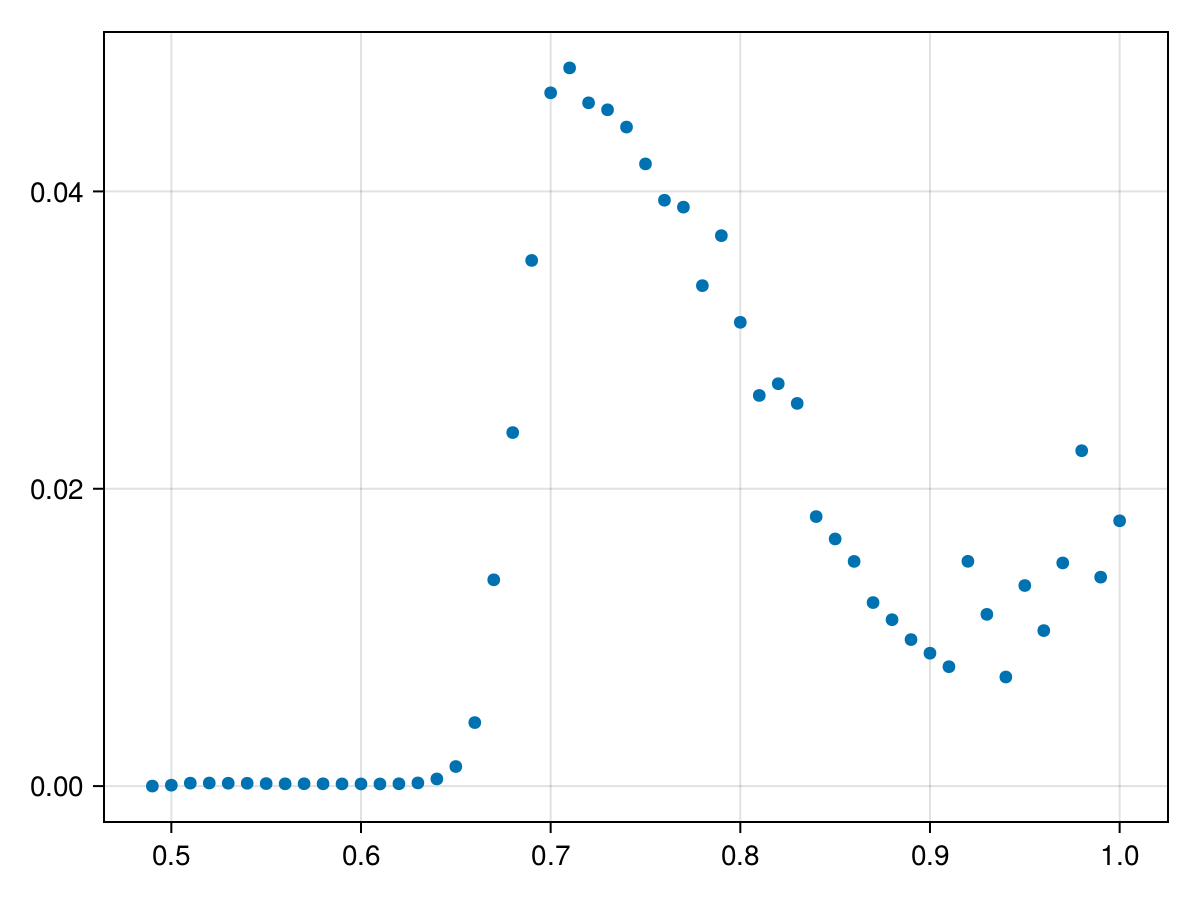

In [63]:
x = 0.1: 0.01 : 1.0
y = mr_f.(x)

plot(x[.!isnan.(y)], y[.!isnan.(y)])

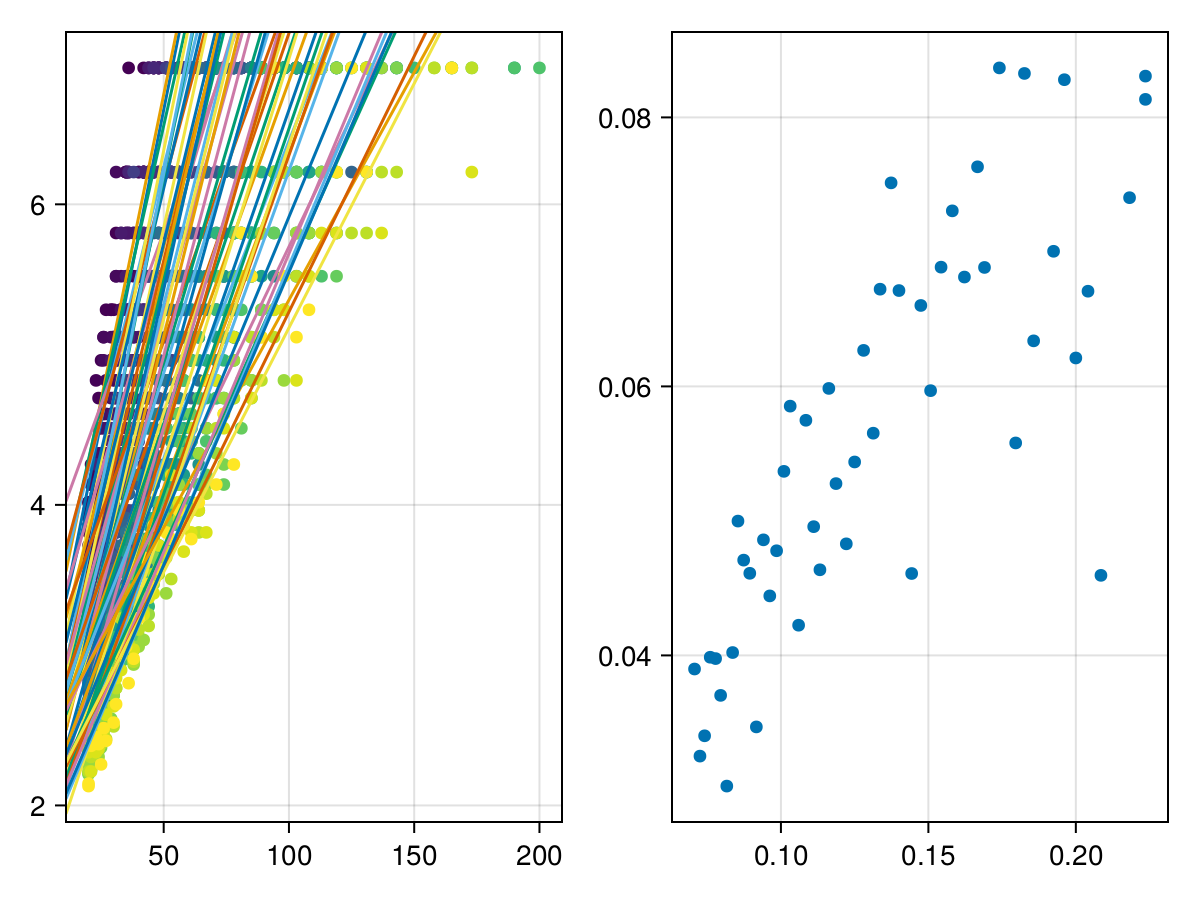

In [248]:
ind = stab[:] .> 0
f,ax = scatter(N_mat[ind], -log.(stab[ind]), color = M_mat[ind])

a_vec = zeros(M)
for i = 1:M
    ind = stab[:,i] .> 0
    x = N_mat[ind,i]
    y = -log.(stab[ind,i])

    data = (; x, y)
    mod = lm(@formula(y~x), data)
    ablines!(ax, GLM.coef(mod)...)

    a_vec[i] = GLM.coef(mod)[2]
end

ax2 = Axis(f[1,2])
scatter!(ax2, 1 ./ sqrt.(m_vec), a_vec)

f

In [250]:
x = 1 ./ sqrt.(m_vec)
y = a_vec
data = (; x, y)
    mod = lm(@formula(y~x), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.0216711   0.0039482  5.49    <1e-05  0.0137327  0.0296095
x            0.262734    0.027928   9.41    <1e-11  0.206581   0.318887
────────────────────────────────────────────────────────────────────────

In [20]:
save("../Results/Figures/size_correlations.pdf", f)
save("../Results/Figures/size_correlations.svg", f)

CairoMakie.Screen{SVG}


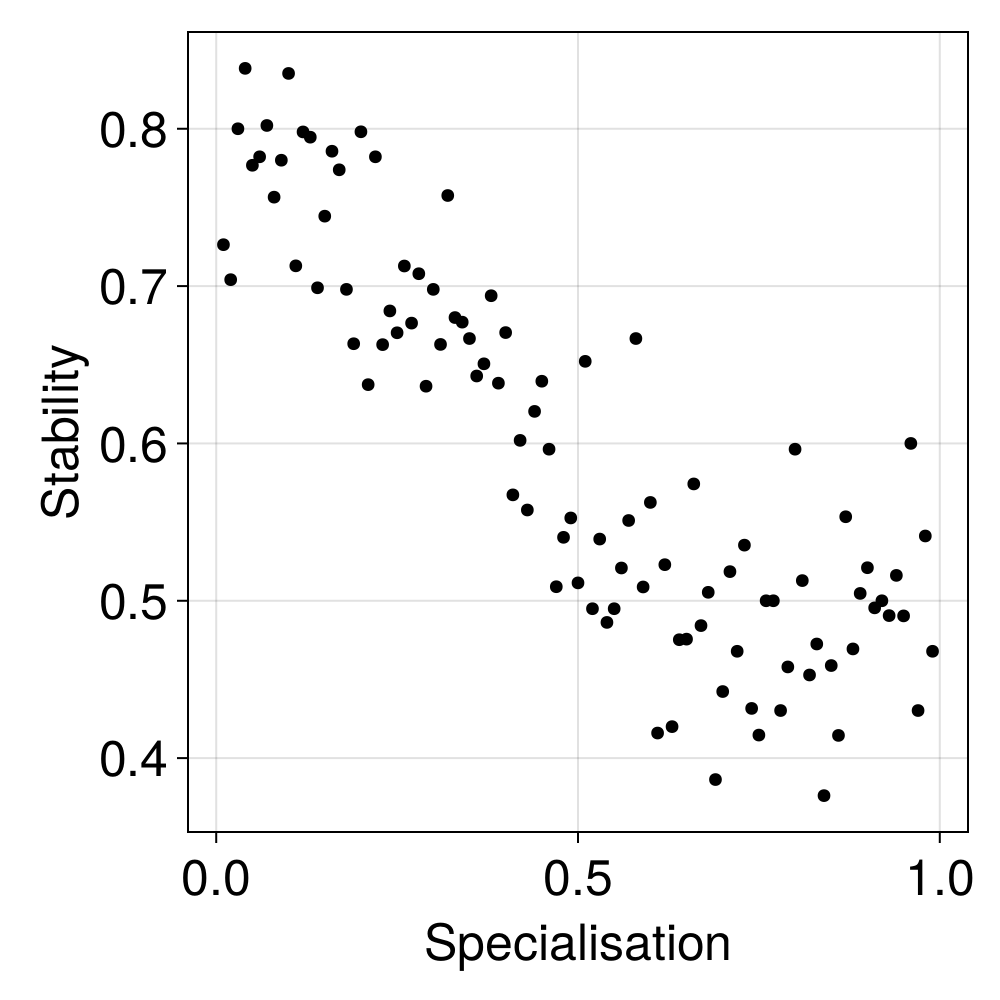

In [24]:
res = load("../Results/data/new_sims/overlap_stabiltiy.jld2")

stab = [x.re < 0 for x = res["l"]]
pvec = hcat(res["p"]...)

d = 0.01
xvec = d:d:1.0
stab_var = [stab[(i .< pvec[1,:] .< i + d)] |> var for i = xvec]
stab = [stab[(i .< pvec[1,:] .< i + d)] |> mean for i = xvec]

f = Figure(size = (500,500))
ax = Axis(f[1,1], xlabel = "Specialisation", ylabel = "Stability", 
    xticklabelsize = 25, yticklabelsize = 25,
    xlabelsize = 25, ylabelsize = 25)

plot!(ax, xvec, stab, color = (:black))
# errorbars!(ax, xvec,stab, stab_var)
# ylims!(0,1)

f

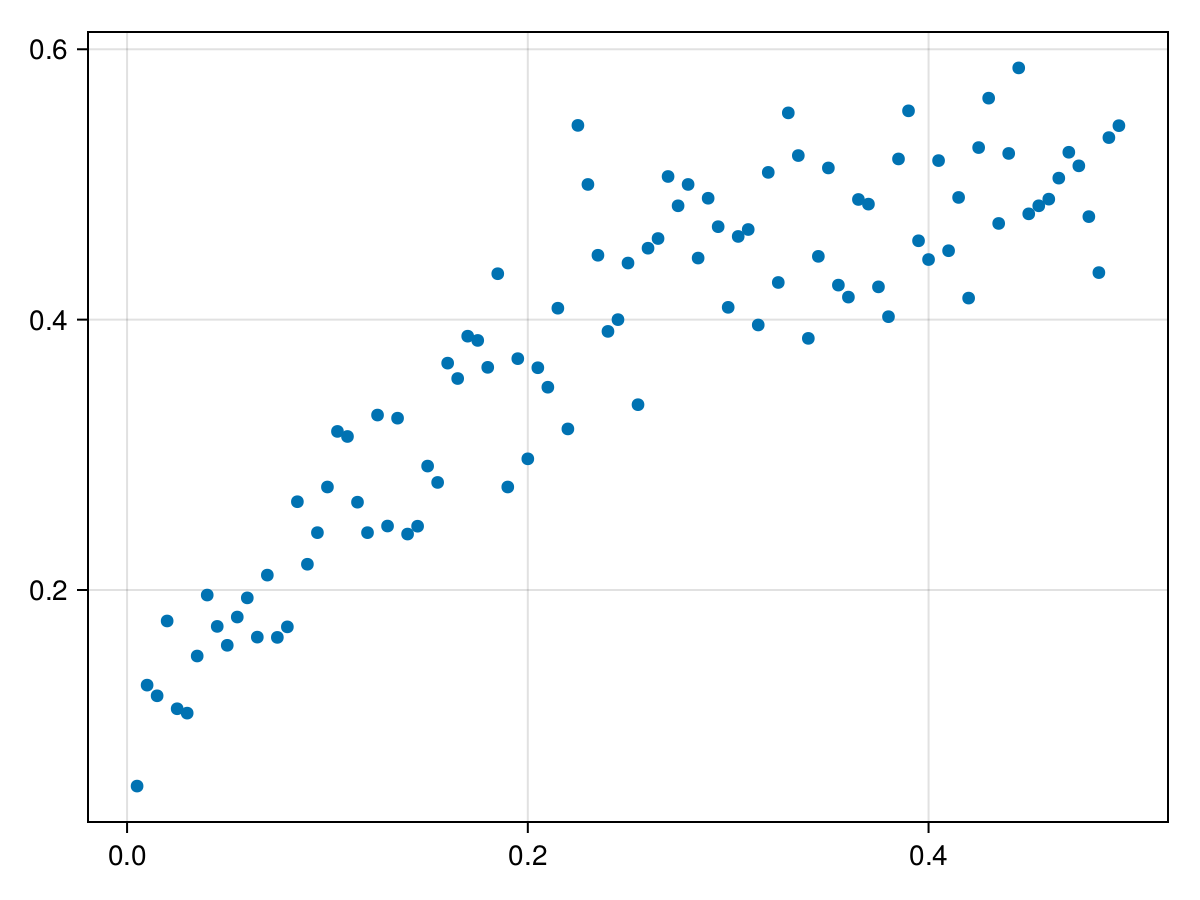

In [62]:
res = load("../Results/data/new_sims/overlap_stabiltiy.jld2")

stab = [x.re < 0 for x = res["l"]]
pvec = hcat(res["p"]...)

d = 0.005
xvec = d:d:1.0
stab = [stab[(i .< pvec[1,:] .< i + d)] |> mean for i = xvec]


plot((xvec), stab)


In [49]:
stab = [x.re < 0 for x = res["l"]]
stab = [stab[pvec[2,:] .== i] |> mean for i = unique(pvec[2,:])]

4-element Vector{Float64}:
 0.35291766586730616
 0.36192384769539077
 0.35407640803465934
 0.3997564935064935

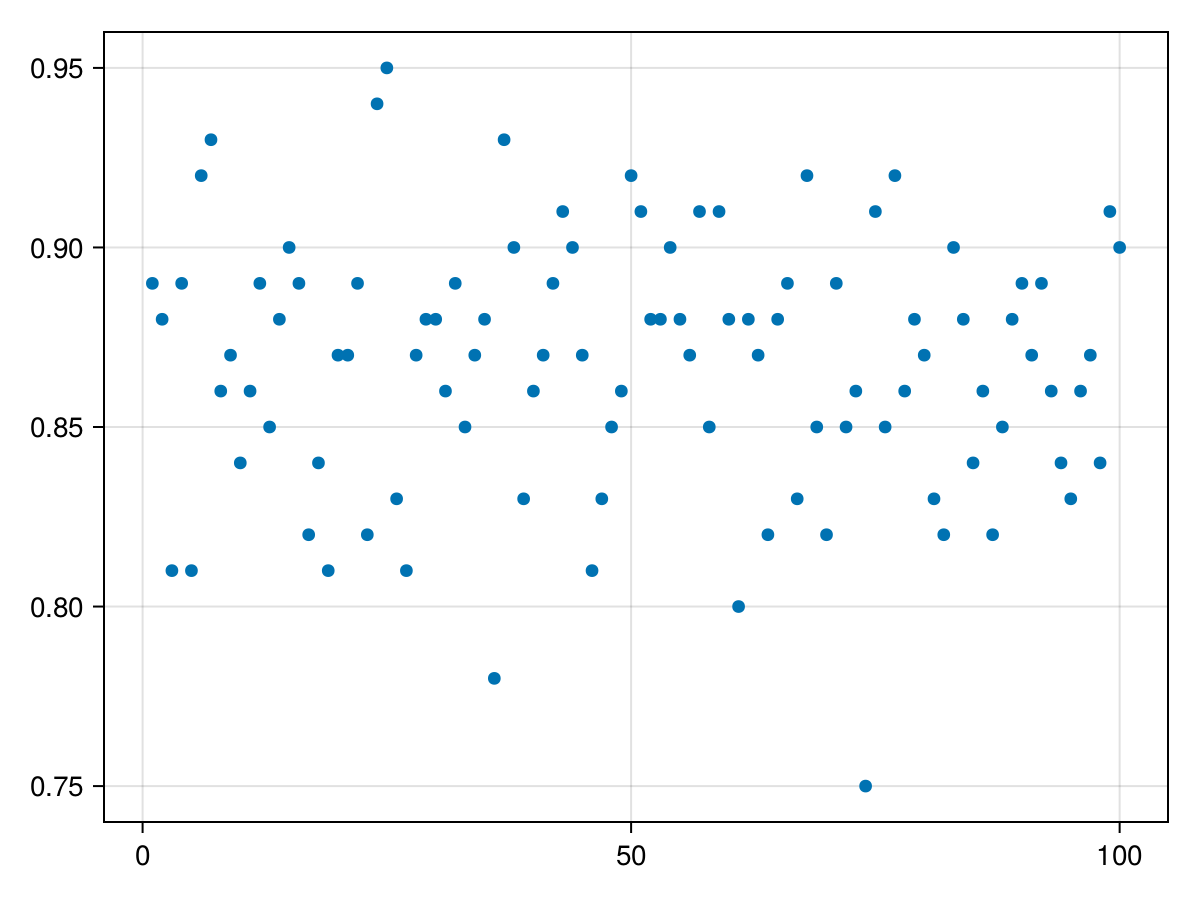

In [21]:
res = load("../Results/data/new_sims/coherence_stabiltiy.jld2")

stab = [x.re < 0 for x = res["l"]]

plot(mean(stab,dims=2)[:,1])

In [174]:
norm.(eigen(J).vectors) |> heatmap

LoadError: UndefVarError: `J` not defined

In [369]:
p.s.χ

1×10 Matrix{Float64}:
 0.2  0.2  0.2  0.2  0.0  0.0  0.0  0.0  0.0  0.2

In [212]:
J .= 0
    #loop over consumers
    for i = 1:p.N
        for j = 1:p.N
            #dxi/dxi
            if i == j
                J[i,i] = p.s.α[i] * (1 - p.s.Λ[i]) * (p.e.gx[i] - p.e.mx[i])
            end
        end
        
        for a = 1:p.M
            #dxi/dya
            J[i, a + p.N] = p.s.α[i] * ( 
                (1 - p.s.Λ[i]) * (
                (p.e.gs[i] * p.s.χ[i,a] * p.e.fy[i,a])
                ) +
                (p.s.Λ[i] * p.e.λy[i,a])
            )
        end

    end

In [219]:
p.s.χ .* p.e.fy



100×200 Matrix{Float64}:
 0.0        0.030303   0.0        …  0.0        0.0  0.0  0.030303
 0.0        0.0        0.0           0.0        0.0  0.0  0.0
 0.0344828  0.0        0.0           0.0        0.0  0.0  0.0
 0.0        0.0357143  0.0357143     0.0        0.0  0.0  0.0357143
 0.0        0.0        0.0344828     0.0        0.0  0.0  0.0
 0.0        0.0285714  0.0        …  0.0        0.0  0.0  0.0285714
 0.0        0.0        0.0           0.0        0.0  0.0  0.0
 0.0        0.0        0.0           0.0        0.0  0.0  0.030303
 0.0        0.0357143  0.0           0.0        0.0  0.0  0.0
 0.0555556  0.0555556  0.0           0.0        0.0  0.0  0.0
 0.0        0.0        0.0        …  0.0357143  0.0  0.0  0.0357143
 0.0        0.0333333  0.0           0.0333333  0.0  0.0  0.0
 0.0357143  0.0357143  0.0           0.0357143  0.0  0.0  0.0
 ⋮                                ⋱                       
 0.037037   0.037037   0.0           0.0        0.0  0.0  0.0
 0.0        0.04    

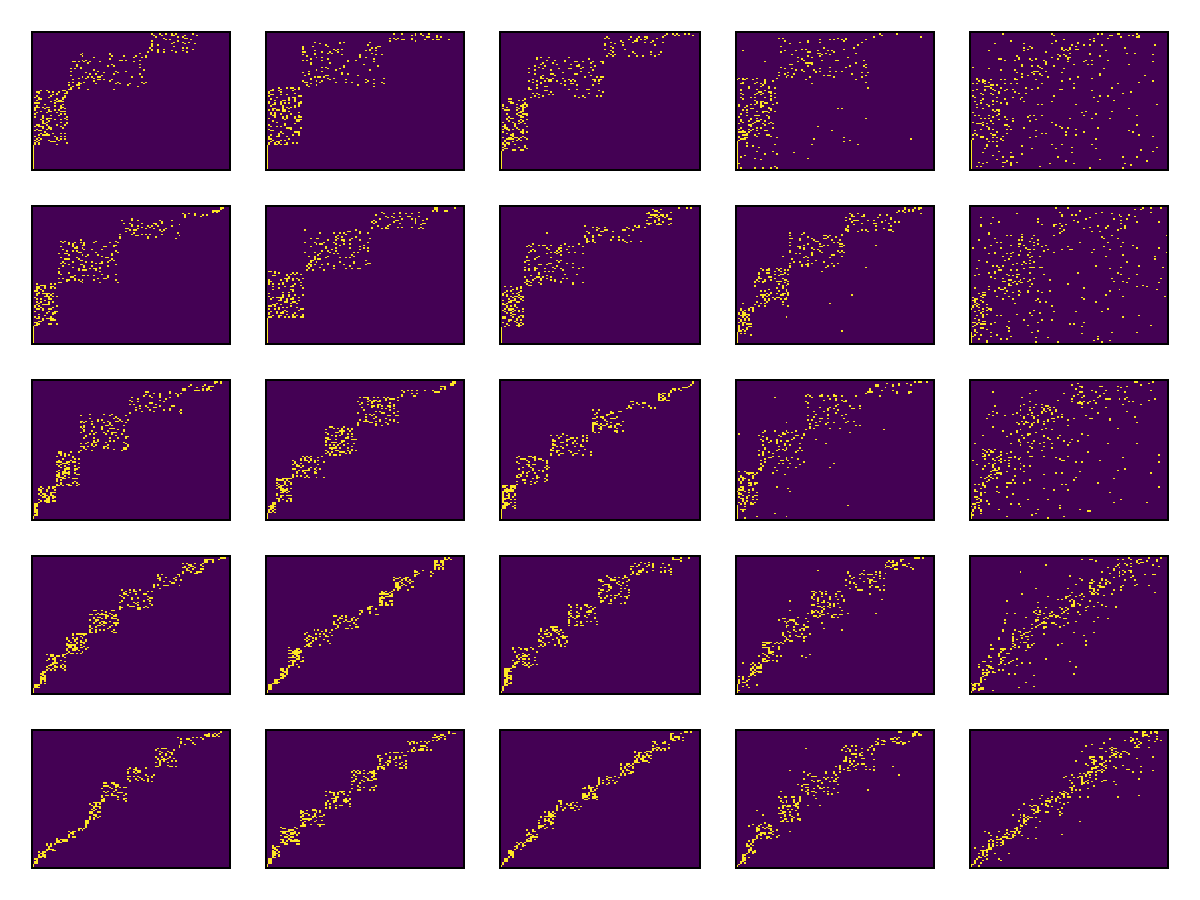

In [290]:
M = 100
λd = 3.0

h_vec = range(-2,2, length = 5)
T_vec = 10 .^ range(-2,0, length=5)

f = Figure()

for i = 1:5
    for j= 1:5
        ax = Axis(f[i,j])
        hidedecorations!(ax)
        heatmap!(ax, coherence_D(M,λd,h_vec[i],T_vec[j]))
    end
end
f

In [335]:
function get_switching_parameters(N,M,σ)

    gx = rand(Uniform(0.75,1.0)) .+ rand(Uniform(-σ,σ), N)
    gs = rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), N)
    gw = -rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), N)
    mx = rand(Uniform(1.0,1.25)) .+ rand(Uniform(-σ,σ), N)
    
    fy = rand(Uniform(σ,2)) .+ rand(Uniform(-σ,σ),N,M)
    hy = rand(Uniform(σ,2)) .+ rand(Uniform(-σ,σ),N,M)

    # fy = ones(N,M)
    # hy = ones(N,M)
    
    λy = rand(Uniform(-1,1)) .+ rand(Uniform(-σ,σ),N,M)
    # ωy = rand(Uniform(-1,1)) .+ rand(Uniform(-σ,σ),N,M)
    # λy = zeros(N,M)

    iy = rand(Uniform(σ,0.5)) .+ rand(Uniform(-σ,σ), M)
    oy = rand(Uniform(1.0,2.0)) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,iy,oy)
end

function coherence_D(M,λd,h,T)
    #create skeleton
    TL = fill(-Inf,M)
    TL[1] = 1
    
    D = zeros(M,M)
    p = 0
    for i = 2:M
        ind = 1:(i-1)
    #choose base
        pb = (TL[ind] / maximum(TL[ind])) .^ h
        b = sample(ind, Weights(pb[ind]))
        D[b,i] = 1
        TL[i] = TL[b] + 1
    end
    
    #sort by TL
    TLind = sortperm(TL)
    D = D[TLind, TLind]
    TL = TL[TLind]
    
    #add extra links
    k = rand(Poisson(λd), M)
    x = TL .- TL'
    pl = exp.(-abs.(x .- 1)/ T)
    pl[findall(D .== 1)] .= 0
    pl[diagind(pl)] .= 0
    
    for i = 2:M
        D[sample(1:M, Weights(pl[i,:]), k[i]), i] .= 1
    end
    
    return(D)
end

function random_community(N,M,f,h,T)
    U = rand(N,M) ./ (N*M)
    U[:,end] .= 0
    
    D = coherence_D(M,3.0,h,T)
    [D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
    D[isnan.(D)] .= 0.0
    
    Λ = fill(rand(),N)
    
    s = MiCRM_stability.get_structural_params(U,D,Λ)
    e = f(N,M, 0.1)
    u = MiCRM_stability.util_params(N,M,s,e)
    
    p = MiCRM_stability.Parameters(N,M,s,e,u)

    return(p)
end

random_community (generic function with 1 method)

In [334]:
N,M = 50,100
U = rand(N,M) ./ (N*M)
U[:,end] .= 0

D = coherence_D(M,3.0,h,T)
[D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
D[isnan.(D)] .= 0.0

Λ = fill(rand(),N)

s = MiCRM_stability.get_structural_params(U,D,Λ)

s.ψ

50×100×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0